# Session 2: Time series analysis

This material was prepared for the Australian Water School by Chris Turnadge (chris.turnadge@csiro.au) and was presented on 10 June 2021.

The second session of the Python course is focused on the analysis of hydrological and geoscientific time series data. Topics covered include data wrangling tools specific to time series analysis, convolution and deconvolution, and harmonic analysis. We'll illustrate this with hydrological and geoscientific datasets. The third session of the course next week will look in greater detail into the analysis and interpolation of spatial datasets, including combining Python with QGIS.

# 0.1. Import packages

First, we need to import all of the Python packages that we'll need for this session.

These are:
* <b>numpy</b> for numerical computation - including linear algebra operations, and a Fourier transform routine.
* <b>scipy</b> for scientific computation - including a host of optimisation algorithms, and a host of signal processing routines.
* <b>pandas</b> for importing and processing time series data.
* <b>matplotlib</b> for creating output plots.
* <b>pyplot</b>, because it is often handy to call pyplot directly, rather than via matplotlib.

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Let's quickly check the version numbers for each package, since this can be the cause of many problems when sharing code!

In [2]:
print('numpy: ', np.__version__)
print('scipy: ', sc.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', mpl.__version__)

('numpy: ', '1.16.5')
('scipy: ', '1.2.1')
('pandas: ', u'0.24.2')
('matplotlib: ', '2.2.3')


# 0.2. Create default plotting function for time domain plots

Next, we'll create a customised plotting function for the plotting of time series data in the time (as opposed to frequency) domain. This is partly to change some of the plotting defaults to make plots that are more appropriate to time series data; e.g. increasing the widths of plots. It also means we can have a consistent look when creating many plots. The first code block changes some of the default settings for matplotlib. The second code block defines a function that we can call each time we create a new figure.

In [3]:
%matplotlib inline

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams[ 'font.size'        ] = 8
mpl.rcParams[ 'xtick.direction'  ] = 'out'
mpl.rcParams[ 'ytick.direction'  ] = 'out'       
mpl.rcParams[ 'lines.linewidth'  ] = 1.0     
pd.plotting.register_matplotlib_converters()

def create_formatted_plot(xlabel, ylabel, title=''):
    f,s = plt.subplots(figsize=[20.00/2.54, 6.00/2.54])
    s.set_title(title, loc='left', fontsize=8)
    s.set_xlabel(xlabel)
    s.set_ylabel(ylabel)
    s.spines['top'].set_visible(False)
    s.spines['right'].set_visible(False)
    s.grid(which='major', axis='both', c='silver', ls='-', lw=0.5)                            
    s.grid(which='minor', axis='both', c='silver', ls='-', lw=0.5)                            
    s.ticklabel_format(useOffset=False)
    plt.tight_layout()
    return f,s

# 1.0. Data wrangling for time series data

We'll kick things off with a bit of data wrangling specific to time series data. We'll read a CSV dataset into a dataframe object. Pandas allows data to be indexed using "datetimes", instead of the usual sequence of integers (i.e. 0, 1, 2, etc.) The <i>"parse_dates"</i> keyword tells pandas that we want to use datetimes as indices, and the <i>"index_col"</i> keyword identifies the column in the CSV file that contains the datetime information.

In [4]:
pahute = pd.read_csv('Pahute_Mesa.csv', index_col=0, parse_dates=True)

Let's take a look at the raw data, which is a time series of groundwater hydraulic head from the Pahute Mesa area of California: (which are also located in the "Session2" folder on the GitHub repository)

In [ ]:
pahute

And let's plot the data for visual inspection:

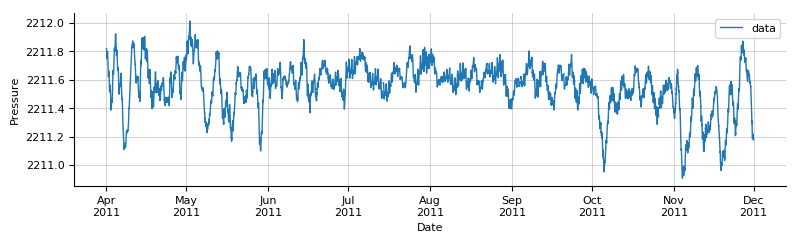

In [6]:
f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.GW, label='data') # x array is inferred
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
plt.legend()

plt.show();

First, let's check the dataset for NaN values:

In [ ]:
pahute[pahute.GW.isna()]

We can plot these in orange, to identify when the gaps occurred:

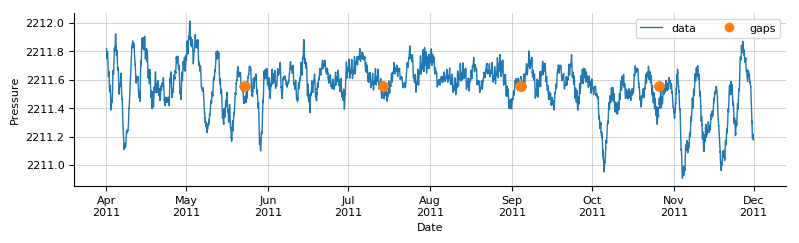

In [8]:
f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.GW, label='data')
for dt in pahute.index[pahute.GW.isna()]:
    s.plot(dt, pahute.GW.mean(), 'o', c='C1')
s.plot(dt, pahute.GW.mean(), 'o', c='C1', label='gaps')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
plt.legend(ncol=2)

plt.show();

And we can zoom into sections of the time series that contains gaps. For example:

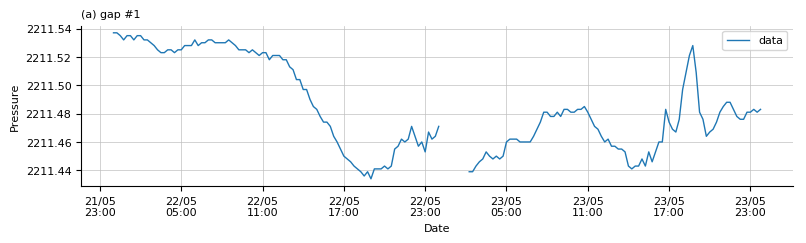

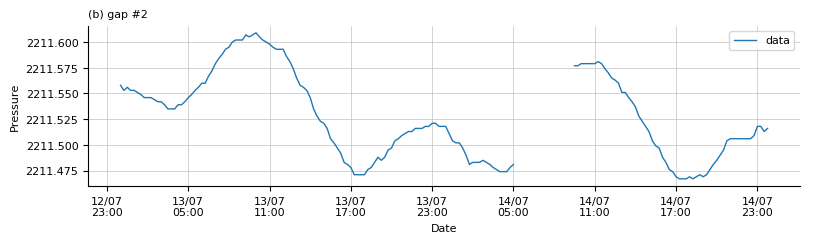

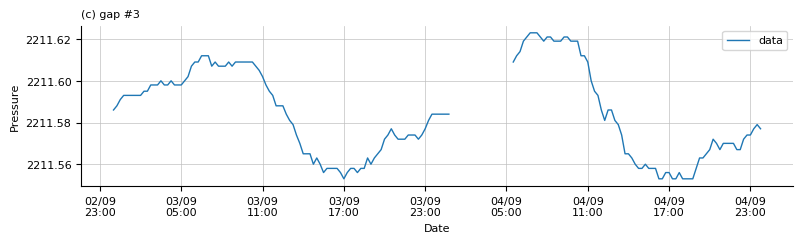

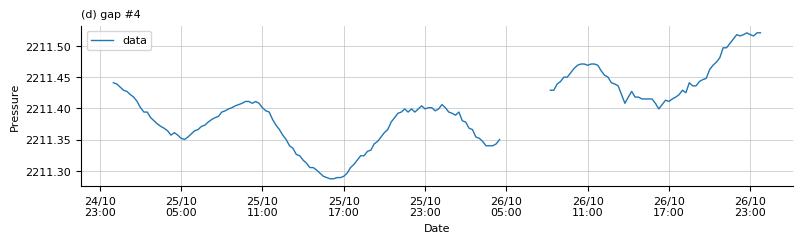

In [9]:
f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(a) gap #1')
s.plot(pahute.GW['2011-05-22':'2011-05-23'], label='data')
plt.legend(ncol=2)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(b) gap #2')
s.plot(pahute.GW['2011-07-13':'2011-07-14'], label='data')
plt.legend(ncol=2)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(c) gap #3')
s.plot(pahute.GW['2011-09-03':'2011-09-04'], label='data')
plt.legend(ncol=2)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(d) gap #4')
s.plot(pahute.GW['2011-10-25':'2011-10-26'], label='data')
plt.legend(ncol=2)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))

plt.show();

We can remove these using the <i>dropna</i> command:

In [10]:
pahute2 = pahute.dropna(inplace=False)

Let's also check for the presence of duplicated datetime values:

In [11]:
pahute2[pahute2.index.duplicated()]

,GW,BA
Datetime,,
2011-04-27,2211.659,26.736
2011-06-18,2211.581,26.689
2011-08-09,2211.584,26.797
2011-09-30,2211.621,26.902


We can remove these using the <i>duplicated</i> command:

In [12]:
pahute2 = pahute2[~pahute2.index.duplicated(keep='first')]

These data appear to be sampled every five minutes, but because we removed all of the NaN values, the data are no longer  sampled uniformly in time. To do this, we create a new sequence of datetimes at a five minute frequency. Then we extract all data from our dataframe at these new datetimes by using the <i>"reindex"</i> command:

In [ ]:
pahute3 = pahute2.reindex(pd.date_range(start=pahute.index[0], end=pahute.index[-1], freq='5T'))
pahute3

## 1.1. Gap filling

Once we have identified that we do have gaps in our data, and identified at which datetimes these gaps occurred, we can fill these gaps. Gap filling can be a very tedious, repetitive and time consuming task when performed using software like Microsoft Excel. Instead, gap filling can be performed in a single line of Python code. A scripted approach to gap filling can also help workflows to be run from start to finish, which makes them repeatable. This is often needed, since our work typically involves multiple iterations.

The simplest method of interpolation, and which I most commonly use, is linear interpolation. This is suitable for relatively short data gaps. Note that this method assumes that data are uniformly spaced in time. If this is nnot the case, the keyword <i>method="time"</i> can be used instead.

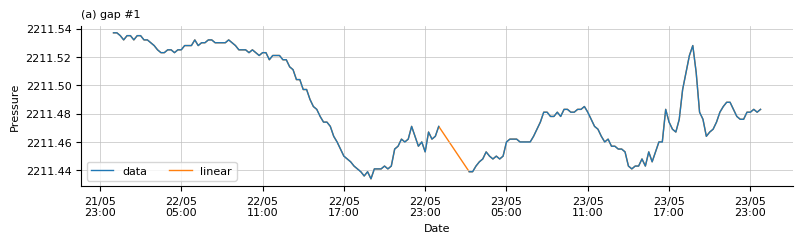

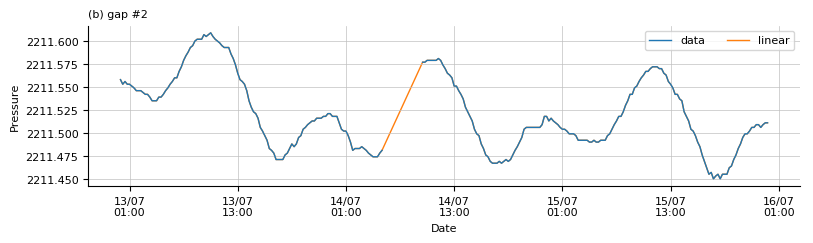

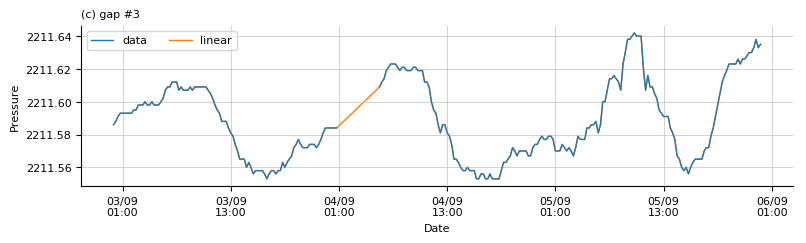

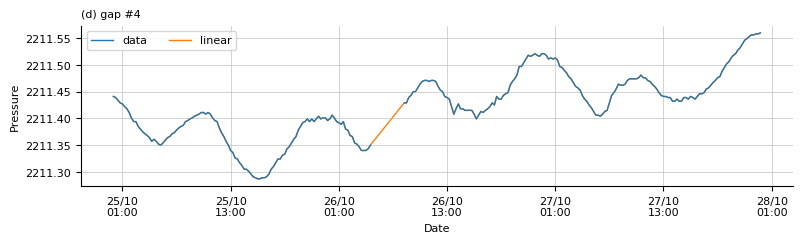

In [14]:
pahute = pd.read_csv('Pahute_Mesa.csv', index_col=0, parse_dates=True)
pahute = pahute[~pahute.index.duplicated(keep='first')]

pahute2 = pahute.interpolate(method='linear', inplace=False) # or 'time', 'polynomial', 'spline', etc.

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(a) gap #1')
s.plot(pahute.GW ['2011-05-22':'2011-05-23'], label='data',   zorder=2)
s.plot(pahute2.GW['2011-05-22':'2011-05-23'], label='linear', zorder=1)
plt.legend(ncol=2)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(b) gap #2')
s.plot(pahute.GW ['2011-07-13':'2011-07-15'], label='data',   zorder=2)
s.plot(pahute2.GW['2011-07-13':'2011-07-15'], label='linear', zorder=1)
plt.legend(ncol=2)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(c) gap #3')
s.plot(pahute.GW ['2011-09-03':'2011-09-05'], label='data',   zorder=2)
s.plot(pahute2.GW['2011-09-03':'2011-09-05'], label='linear', zorder=1)
plt.legend(ncol=2)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(d) gap #4')
s.plot(pahute.GW ['2011-10-25':'2011-10-27'], label='data',   zorder=2)
s.plot(pahute2.GW['2011-10-25':'2011-10-27'], label='linear', zorder=1)
plt.legend(ncol=2)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))

plt.show();

## 1.2. Resampling

Often data are sampled at a resolution that is unsuitable for analysis: 
* If data are sampled too frequently, downsampling can be used to reduce the resolution, and the number of samples.


* Alternatively, if data are sampled at a low resolution, upsampling (with interpolation) can be used to increase the resolution, and the number of samples.

### 1.2.1. Downsampling

For example, suppose we wish to downsample our data, which were sampled at 15 minute frequency, to a (lower) hourly frequency. We can achieve this using the <i>"resample"</i> command:

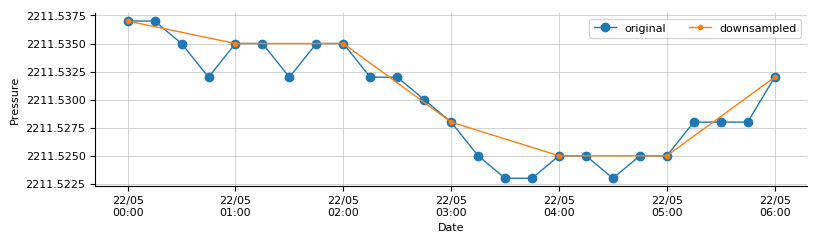

In [15]:
pahute2 = pahute.resample('1H').first() # or mean()

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.GW ['2011-05-22 00:00:00':'2011-05-22 6:00:00'], 'o-', markersize=6, label='original')
s.plot(pahute2.GW['2011-05-22 00:00:00':'2011-05-22 6:00:00'], 'o-', markersize=3, label='downsampled')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))
s.legend(ncol=2)

plt.show();

### 1.2.2. Upsampling

Alternatively, suppose we wish to upsample our data to a (higher) five minute frequency:

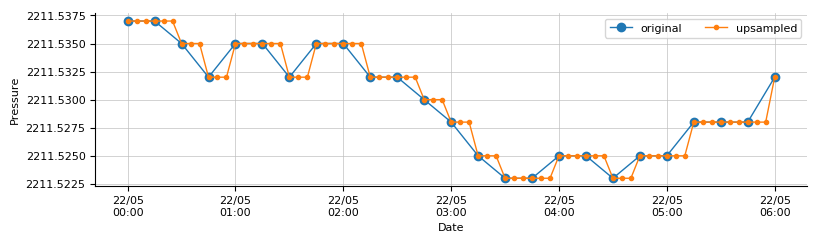

In [16]:
pahute2 = pahute.resample('5T').ffill() # or bfill

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.GW ['2011-05-22 00:00:00':'2011-05-22 6:00:00'], 'o-', markersize=6, label='original')
s.plot(pahute2.GW['2011-05-22 00:00:00':'2011-05-22 6:00:00'], 'o-', markersize=3, label='upsampled')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))
plt.legend(ncol=2)

plt.show();

This is problematic, since the forward and backward filling cannot interpolate between measured points. Instead, we can use a combination of reindexing and interpolation. Reindexing in this way can also be useful for correcting logger drift; i.e. when internal clocks drift off of a set sampling frequency. Reindexing can be used to interpolate values at intended sampling times.

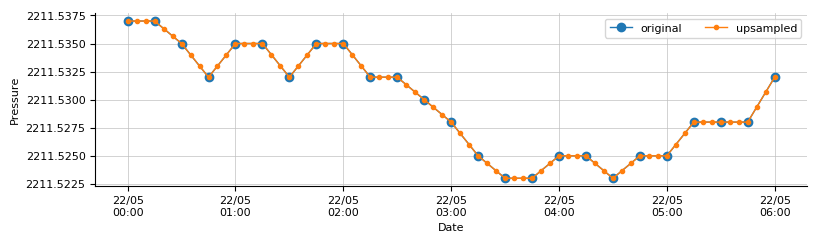

In [17]:
pahute2 = pahute.reindex(pd.date_range(start=pahute.index[0], end=pahute.index[-1], freq='5T'))
pahute2 = pahute2.interpolate(method='linear', inplace=False)

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.GW ['2011-05-22 00:00:00':'2011-05-22 6:00:00'], 'o-', markersize=6, label='original')
s.plot(pahute2.GW['2011-05-22 00:00:00':'2011-05-22 6:00:00'], 'o-', markersize=3, label='upsampled')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))
plt.legend(ncol=2)

plt.show();

## 1.3. Detrending

Often detrending of measured data is required before further analysis. Detrending can serve to remove low frequency, large period trends, such as seasonal effects. Or it can be used to remove high frequency, small period trends, such as random noise. Detrending can be performed in the time or frequency domain, and we will examine both types of methods.

### 1.3.1. Time domain methods

#### 1.3.1.1 Moving average filtering

My use of detrending in the time domain has been limited to moving average filtering. While this can be applied in Excel (for example), it is really easy to test the effects of varying window sizes when implemented using Python:

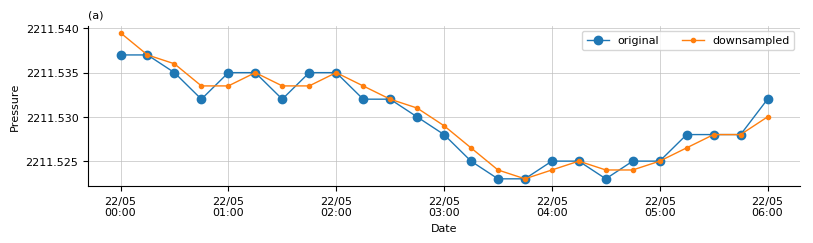

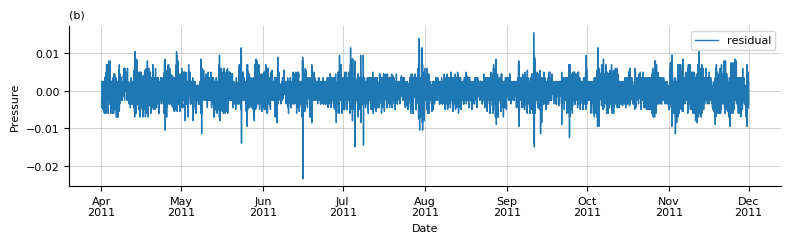

In [18]:
pahute2 = pahute.rolling(window=2, win_type='boxcar', center=True).mean().dropna()

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(a)')
s.plot(pahute.GW ['2011-05-22 00:00:00':'2011-05-22 6:00:00'], 'o-', markersize=6, label='original')
s.plot(pahute2.GW['2011-05-22 00:00:00':'2011-05-22 6:00:00'], 'o-', markersize=3, label='downsampled')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m\n%H:%M'))
plt.legend(ncol=2)

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure', title='(b)')
s.plot(pahute.GW-pahute2.GW, label='residual')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
plt.legend(ncol=2)

plt.show();

### 1.3.2. Frequency domain methods

Frequency domain methods provide opportunities to filter data in a variety of ways:

* <b>High-pass</b> filtering can be used to exclude signals with relatively <b>low frequencies</b> / small periods --  for example, seasonal trends. 


* <b>Low-pass</b> filtering can be used to exclude signals with relatively <b>high frequencies</b> / large periods -- for example, random noise.


* <b>Band-pass</b> filtering can be used to exclude signals that occur <b>outside</b> a given frequency range.


* <b>Band-stop</b> filtering can be used to exclude signals that occur <b>within</b> a given frequency range.

Before we can look at the effects of these filters, we'll need to define a routine to calculate amplitude spectra. We will calculate these using the Fourier transform. This method assumes that a given time series can be decomposed into a finite number of sinusoidal signals which, when summed, result in an approximation of the time series of interest. The number of frequencies that can be estimated from a given time series is a function of its length. The maximum frequency is a function of the sampling frequency used when measuring a time series. The Fourier transform is used to calculate the amplitude and phase parameters of each frequency that is present.

We'll define our Fourier transform routine as:

In [19]:
def calculate_fft(data, Fs):
    n = len(data)
    F = np.fft.fftfreq(len(data), 1./Fs)[:int(n/2)]
    A = np.abs(np.fft.fft(data*np.hanning(n)))[:int(n/2)]
    return F,A

We'll also need to define a new type of plot, which we will use when we plot the amplitudes of each frequency:

In [20]:
def frequency_domain_plot(f, s, X, Y, c='C0', title=''):
    s.set_title(title)
    s.plot(X, Y, 'o', c=c, markersize=3, markerfacecolor='none')
    for x,y in zip(X,Y):
        s.plot([x,x], [0.,y], '-', c=c)
    return

And we'll reimport the Pahute Mesa groundwater pressure data, before (1) removing duplicates, (2) removing NaN values, (3) reindexing the dataset, and (4) using a subset of the data to improve the clarity of the following figures.

In [21]:
pahute = pd.read_csv('Pahute_Mesa.csv', index_col=0, parse_dates=True)
pahute = pahute[~pahute.index.duplicated(keep='first')]
pahute = pahute.reindex(pd.date_range(start=pahute.index[0], end=pahute.index[-1], freq='15T'))
pahute.interpolate(method='linear', inplace=True)
pahute = pahute[:500]

For frequency domain analyses, we need a dataset that has a zero mean value. One way of achieving this is to subtract the mean value from the time series:

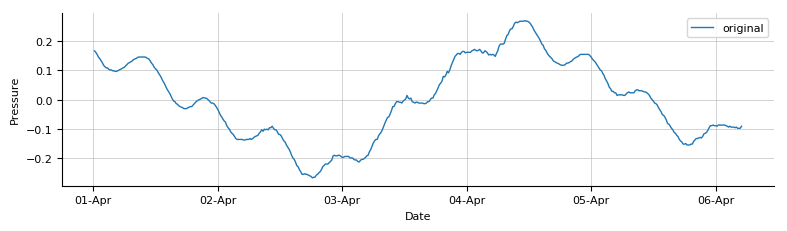

In [22]:
pahute.GW = pahute.GW-pahute.GW.mean()

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.GW, label='original')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
plt.legend(ncol=2)

plt.show();

For demonstration purposes, we'll consider Earth tide influences on the Pahute Mesa groundwater pressure time series. We'll focus on frequencies of up to two cycles per day, as this range includes the 5-12 dominant frequencies. We can define this range as:

#### 1.3.2.1. Low-pass filtering

Here we exclude <b>high</b> frequencies and retain <b>low</b> frequencies:

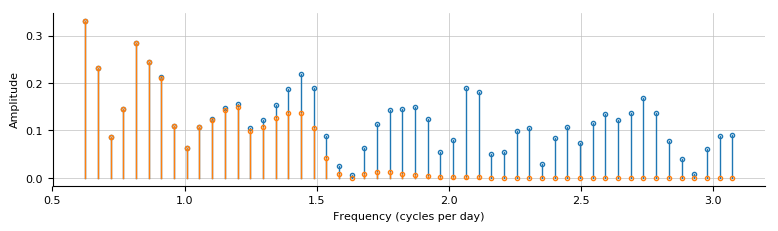

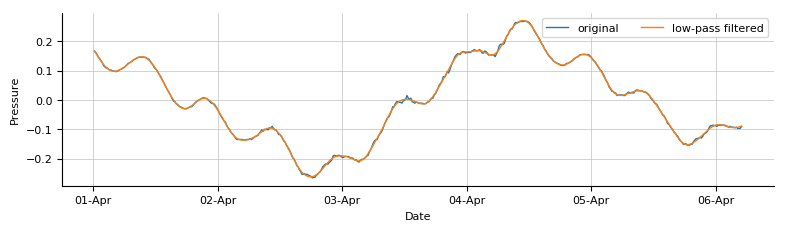

In [23]:
sos = sc.signal.butter(N=7, Wn=1.5, btype='lowpass', fs=24., output='sos')
pahute2 = sc.signal.sosfiltfilt(sos, np.array(pahute.GW))

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Amplitude')
F,A = calculate_fft(pahute.GW, Fs=24.)
frequency_domain_plot(f, s, F[(F>0.6)&(F<3.1)], A[(F>0.6)&(F<3.1)], c='C0')
F,A = calculate_fft(pahute2, Fs=24.)
frequency_domain_plot(f, s, F[(F>0.6)&(F<3.1)], A[(F>0.6)&(F<3.1)], c='C1')

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.index, pahute.GW, label='original')
s.plot(pahute.index, pahute2,   label='low-pass filtered')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
plt.legend(loc=0, ncol=2)

plt.show();

#### 1.3.2.2. High-pass filtering

Here we exclude <b>low</b> frequencies and retain <b>high</b> frequencies:

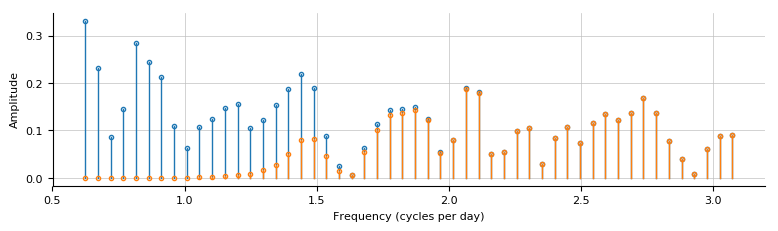

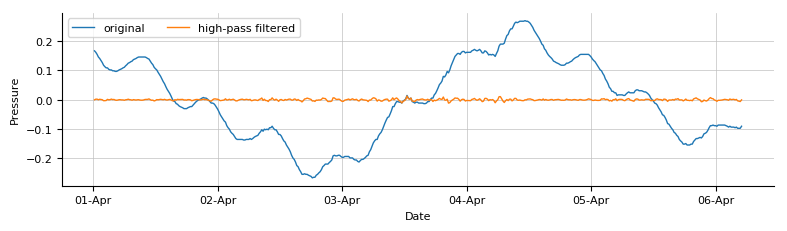

In [24]:
sos = sc.signal.butter(N=7, Wn=1.5, btype='highpass', fs=24., output='sos')
pahute2 = sc.signal.sosfiltfilt(sos, np.array(pahute.GW))

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Amplitude')
F,A = calculate_fft(pahute.GW, Fs=24.)
frequency_domain_plot(f, s, F[(F>0.6)&(F<3.1)], A[(F>0.6)&(F<3.1)], c='C0')
F,A = calculate_fft(pahute2, Fs=24.)
frequency_domain_plot(f, s, F[(F>0.6)&(F<3.1)], A[(F>0.6)&(F<3.1)], c='C1')

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.index, pahute.GW, label='original')
s.plot(pahute.index, pahute2, label='high-pass filtered')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
plt.legend(loc=0, ncol=2)

plt.show();

#### 1.3.2.3. Band-pass filtering

Here we <b>exclude</b> all frequencies <b>except</b> within a defined frequency band:

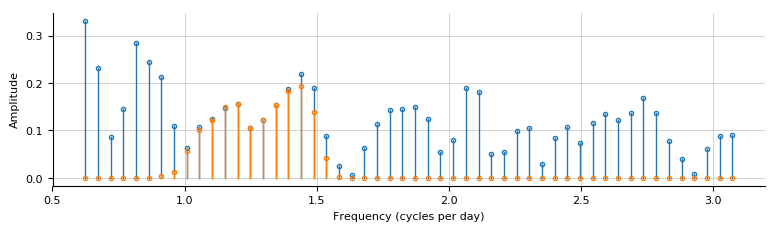

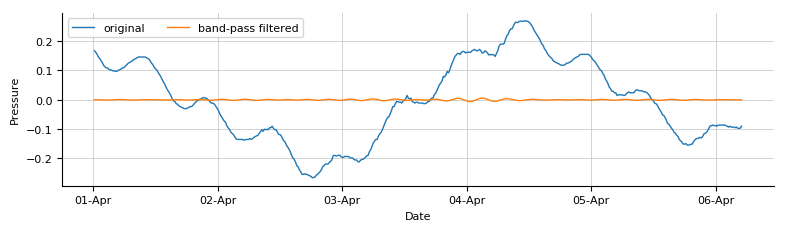

In [25]:
sos = sc.signal.butter(N=7, Wn=[1.0, 1.5], btype='bandpass', fs=24., output='sos')
pahute2 = sc.signal.sosfiltfilt(sos, np.array(pahute.GW))

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Amplitude')
F,A = calculate_fft(pahute.GW, Fs=24.)
frequency_domain_plot(f, s, F[(F>0.6)&(F<3.1)], A[(F>0.6)&(F<3.1)], c='C0')
F,A = calculate_fft(pahute2, Fs=24.)
frequency_domain_plot(f, s, F[(F>0.6)&(F<3.1)], A[(F>0.6)&(F<3.1)], c='C1')

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.index, pahute.GW, label='original')
s.plot(pahute.index, pahute2, label='band-pass filtered')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
plt.legend(loc=0, ncol=2)

plt.show();

#### 1.3.2.3. Band-stop filtering

Here we <b>retain</b> all frequencies <b>except</b> within a defined frequency band:

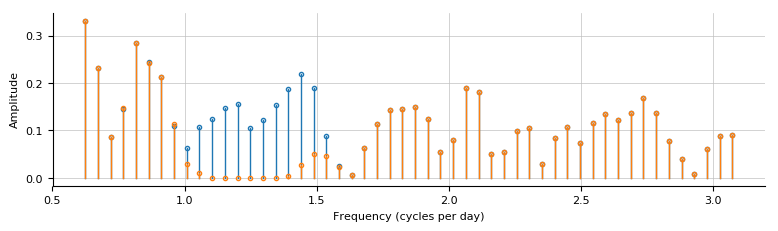

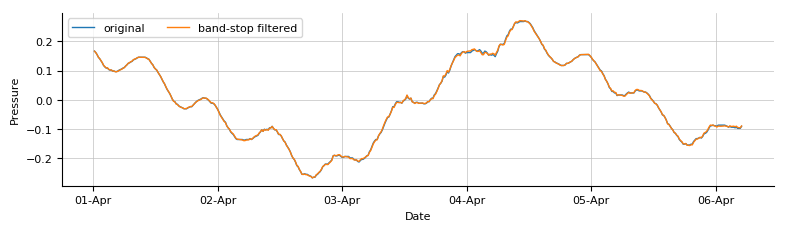

In [26]:
sos = sc.signal.butter(N=7, Wn=[1.0, 1.5], btype='bandstop', fs=24., output='sos')
pahute2 = sc.signal.sosfiltfilt(sos, np.array(pahute.GW))

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Amplitude')
F,A = calculate_fft(pahute.GW, Fs=24.)
frequency_domain_plot(f, s, F[(F>0.6)&(F<3.1)], A[(F>0.6)&(F<3.1)], c='C0')
F,A = calculate_fft(pahute2, Fs=24.)
frequency_domain_plot(f, s, F[(F>0.6)&(F<3.1)], A[(F>0.6)&(F<3.1)], c='C1')

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure')
s.plot(pahute.index, pahute.GW, label='original')
s.plot(pahute.index, pahute2, label='band-stop filtered')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
plt.legend(loc=0, ncol=2)

plt.show();

# 2.0. Interpreting responses to time-lagged signals

Various hydrological processes can be characterised as functions of time lag. For example, both groundwater levels and surface water flows can exhibit time-lagged responses to precipitation. In the following worked examples, we will use a precipitation dataset as the driving process: 

* We will see how convolution can be used to combine a known input with a known response function to result in a time-lagged and diminished signal. 


* We'll use deconvolution to inversely estimate a response function when input and output time series are both measured. 

We'll finish with a demonstration of the application of deconvolution to estimate a response function that characterises groundwater pressure responses to barometric pressure fluctuations.

## 2.1. Import dataset

We'll start by importing a time series of precipitation from the Pedler Creek catchment in South Australia. (Also located in the "Session2" folder on the GitHub repository.)

In [ ]:
precip = pd.read_csv('Pedler_Creek.csv', index_col=0, parse_dates=True, 
                     dayfirst=True, header=0, names=['Datetime', 'PR'])
precip = precip[~precip.index.duplicated(keep='first')]
precip

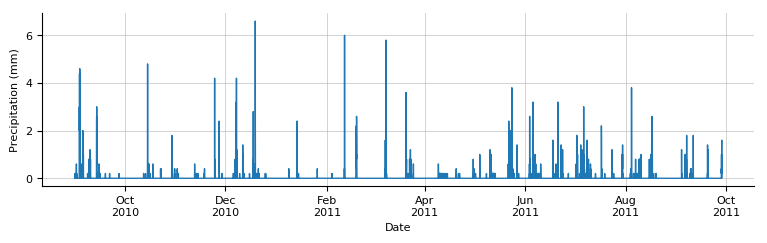

In [28]:
f,s = create_formatted_plot(xlabel='Date', ylabel='Precipitation (mm)')
s.plot(precip.index, precip.PR, label='precip')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))

plt.show();

## 2.2. Correlation in the time domain: Cross-correlation

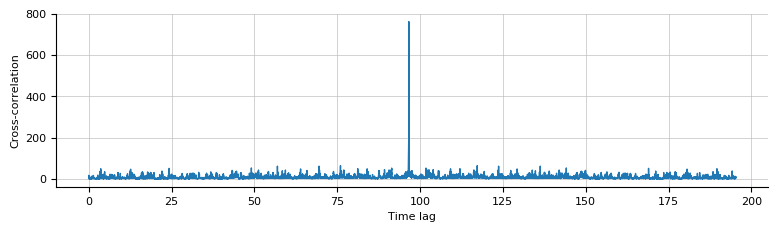

In [29]:
pr = np.array(precip.PR)
c = sc.signal.correlate(pr[100:], pr[:-100], mode='same')
f,s = create_formatted_plot(xlabel='Time lag', ylabel='Cross-correlation')
dt = 15./60./24.
t  = np.arange(0., len(c)*dt, dt) 
s.plot(t, c)

plt.show();

## 2.3. Response kernel types

Thes include impulse response, lagged impulse response, exponential decrease, lagged exponential response, and logarithmic increase.

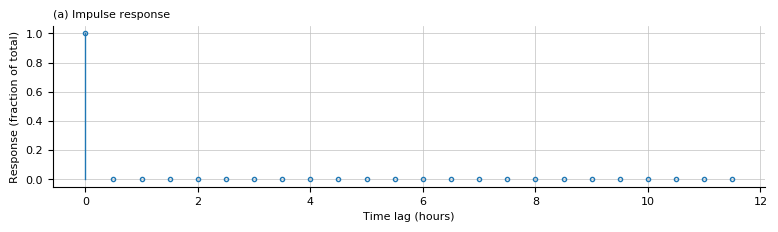

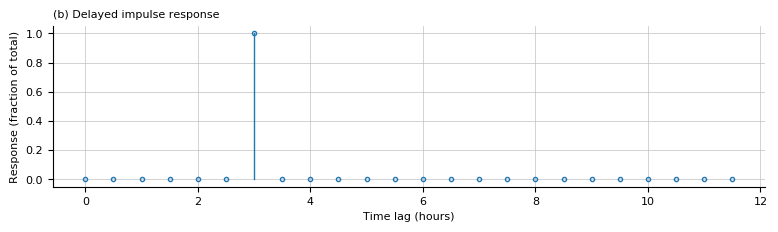

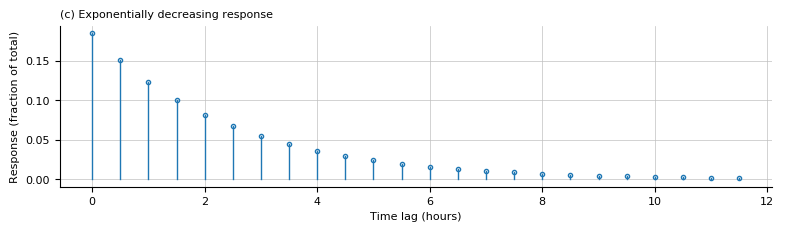

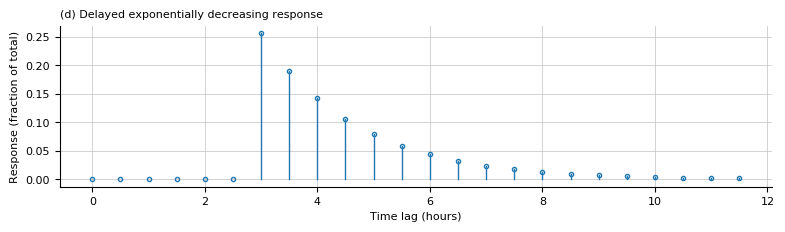

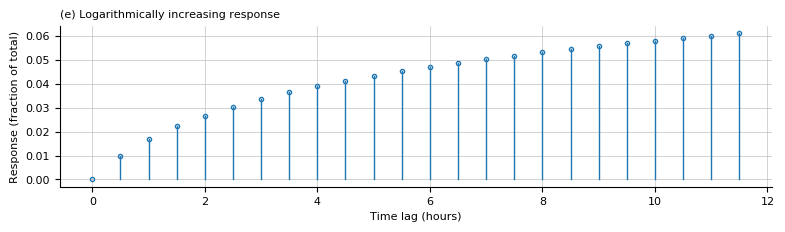

In [30]:
nlags = 24
dt = 0.5 # hours
tl = np.arange(nlags)*dt

gt = np.zeros(nlags)
gt[0] = 1.
f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)', 
                            title='(a) Impulse response')
frequency_domain_plot(f, s, tl, gt)

gt = np.zeros(nlags)
gt[6] = 1.
f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)',
                            title='(b) Delayed impulse response')
frequency_domain_plot(f, s, tl, gt)

gt = 1.5**-tl
gt = gt/np.sum(gt)
f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)',
                            title='(c) Exponentially decreasing response')
frequency_domain_plot(f, s, tl, gt)

gt = np.concatenate([np.zeros(6), 1.8**-tl[:-6]])
gt = gt/np.sum(gt)
f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)',
                            title='(d) Delayed exponentially decreasing response')
frequency_domain_plot(f, s, tl, gt)

gt = np.log10(tl+1)*4.
gt = gt/np.sum(gt)
f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)',
                            title='(e) Logarithmically increasing response')
frequency_domain_plot(f, s, tl, gt)

plt.show();

## 2.4. Convolution (in the forwards direction)

To provide a worked example of a convolution model based on real data, here we convolute the precipitation time series with a known response function:

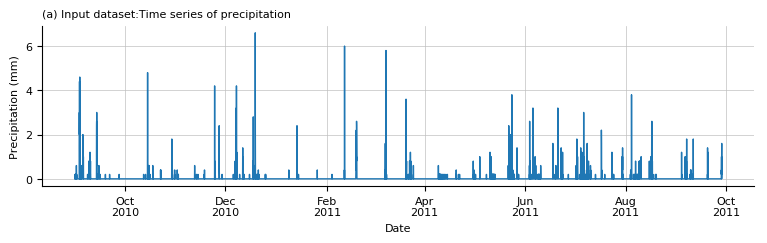

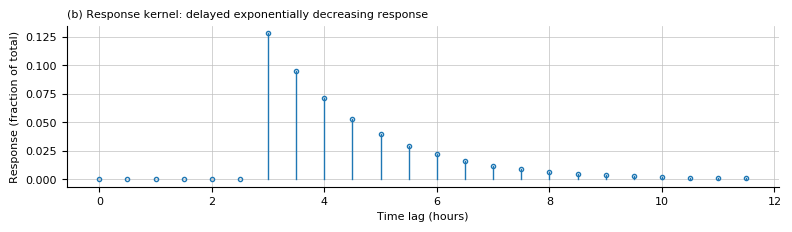

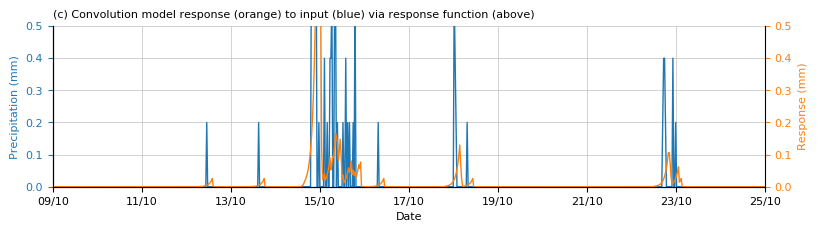

In [31]:
f,s = create_formatted_plot(xlabel='Date', ylabel='Precipitation (mm)', 
                            title='(a) Input dataset:Time series of precipitation')
s.plot(precip.index, precip.PR, label='precip')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))

nlags = 24
dt = 0.5
tl = np.arange(nlags)*dt
gt = np.concatenate([np.zeros(6), 1.8**-tl[:-6]])
gt = gt/np.sum(gt)*0.5
f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)',
                            title='(b) Response kernel: delayed exponentially decreasing response')
frequency_domain_plot(f, s, tl, gt)

out = np.convolve(pr, gt[::-1], 'same')
f,s = create_formatted_plot(xlabel='Date', ylabel='Precipitation (mm)', 
                            title='(c) Convolution model response (orange) to input (blue) '+
                            'via response function (above)')
s.plot(precip.index, pr)
s.yaxis.label.set_color('C0')
s.tick_params(axis='y', colors='C0')
s2 = s.twinx()
s2.plot(precip.index, out, c='C1')
s2.set_ylabel('Response (mm)')
s2.yaxis.label.set_color('C1')
s2.tick_params(axis='y', colors='C1')
s2.set_ylim(s.get_ylim())
s2.spines['top'].set_visible(False)
s.set_xlim('2010-10-9', '2010-10-25')
s.set_ylim(0, 0.5)
s2.set_ylim(0, 0.5)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m'))

plt.show();

## 2.5. Deconvolution (in the backwards direction)

In practice, as hydrologists we typically observe the input and output time series, and use these to characterise the system response. In a linear system, all responses are of the same magnitude, regardless of either (a) the magnitude of the input event or (b) the time between input events. The response of a linear system can be characterised using a response kernel, which can be estimated via deconvolution.  

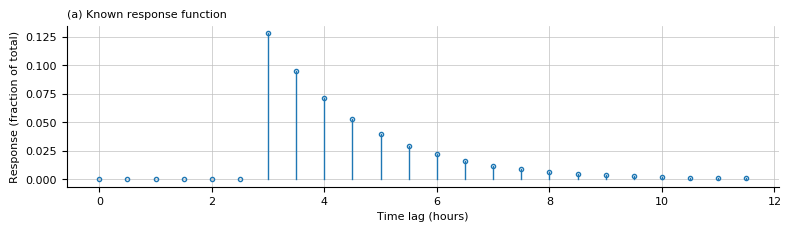

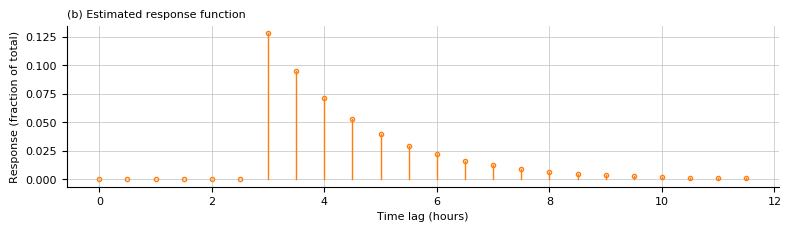

In [32]:
def objective_function(gt):
    global pr, out
    return np.sum((np.convolve(pr, gt[::-1], 'same')-out)**2.)

gt2 = sc.optimize.least_squares(objective_function, np.zeros(nlags)).x

f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)', 
                            title='(a) Known response function')
frequency_domain_plot(f, s, tl, gt,  c='C0')

f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)', 
                            title='(b) Estimated response function')
frequency_domain_plot(f, s, tl, gt2, c='C1')

plt.show();

## 2.6. Example application: Deconvolution of a groundwater level time series

Here we have a worked example of the use of regression deconvolution, based on data collected on Norfolk Island in the South Pacific Ocean. We first import a time series of groundwater pressure head that was measured on the island:

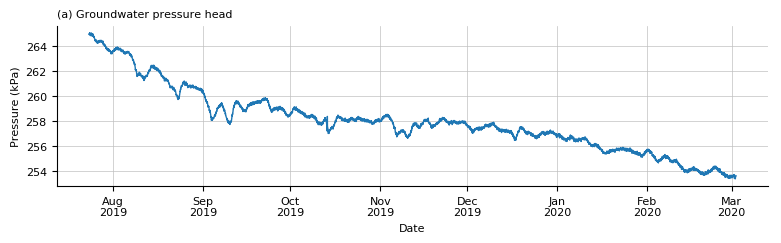

In [33]:
gw = pd.read_csv('Norfolk_Island_GW.csv', index_col=0, parse_dates=True, dayfirst=True)

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure (kPa)', title='(a) Groundwater pressure head')
s.plot(gw.Pressure_kPa, label='barometric')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))

plt.show();

If this aquifer is confined then it is reasonable to assume that these pressures are partly responding to fluctuations in barometric pressure. We therefore import a time series of barometric pressure that was measured at the Norfolk Island airport:

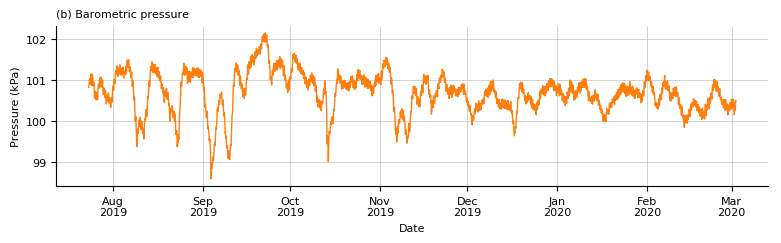

In [34]:
ba = pd.read_csv('Norfolk_Island_BP.csv', index_col=0, parse_dates=True, dayfirst=True)

f,s = create_formatted_plot(xlabel='Date', ylabel='Pressure (kPa)', title='(b) Barometric pressure')
s.plot(ba.Pressure_kPa, c='C1', label='barometric')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))

plt.show();

The aim of the following analysis is to inversely estimate the response function that describes how groundwater pressure head responds to changes in barometric pressure. The response function can indicate the aquifer type (i.e. confined or unconfined). Hydraulic properties such as localised transmissivity can also be estimated from response functions.

The following code block implements a more detailed version of deconvolution but the fundamental method is still the same:

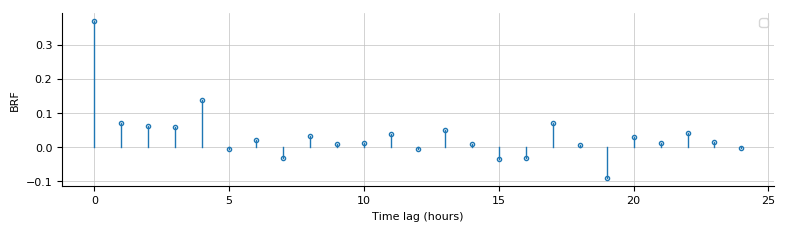

In [35]:
dt = 1./24.
t  = np.arange(0., dt*len(gw)+dt, dt)
d2 = gw.index   
y  = gw.Pressure_kPa
x  = ba.Pressure_kPa
dx = np.diff(x)/dt
dy = np.diff(y)/dt
nlag = 24 
n = len(dx)
nn = range(n) 
lags = np.arange(nlag+1)
nm = nlag+1
v = np.zeros([n, nm])
for i in range(nm):
    j = lags[i]
    k = np.arange(n-j)
    v[j+k, i] = dx[k] 
u1 = np.zeros([n, 10])
u2 = u1.copy()
X = np.hstack([v, u1, u2])
Z = np.hstack([np.ones([n,1]), v])
c = np.linalg.lstsq(Z, dy, rcond=None)[0]
brf = c[np.arange(1, nm+1)]

f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='BRF')
frequency_domain_plot(f, s, lags, brf)
s.legend(loc=0)

plt.show();

Parametric models can subsequently be fitted to response functions, in order to obtain estimates of hydraulic properties. For example, a confined aquifer response can be characterised using a exponentially decreasing kernel function. We can fit this using a least squares optimisation algorithm:

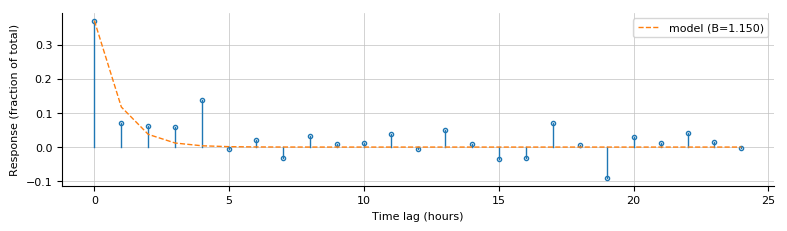

In [36]:
def objective_function(B):
    global lags, brf
    return np.sum((np.exp(-B*lags)*brf[0]-brf)**2.)

B = sc.optimize.least_squares(objective_function, [1.]).x

f,s = create_formatted_plot(xlabel='Time lag (hours)', ylabel='Response (fraction of total)')
frequency_domain_plot(f, s, lags, brf)
s.plot(lags, np.exp(-B*lags)*brf[0], '--', c='C1', label='model (B='+str('%.3f'% B[0])+')')
s.legend(loc=0, ncol=2)

plt.show();

# 3.0. Identifying responses to periodic signals

Various hydrological processes respond to processes that are periodic(i.e. cyclic). For example, groundwater pressures respond to periodic variations in gravity at the Earth's surface. These are driven by the combined movements of the Sun, Moon and planets, which are known as Earth tides. Similarly, both groundwater pressures and estuary stage heights respond to ocean tides.

In the following worked examples, we will look at the presence of periodic signals in groundwater and barometric pressure time series. We'll look at the variety of methods available in the SciPy package for identifying dominant frequencies and to quantify their amplitudes.   

We'll finish with a demonstration that combines two frequency domain methods to characterise aquifer confinement status, based on groundwater pressure responses to barometric pressure fluctuations.

## 3.1. Import datasets

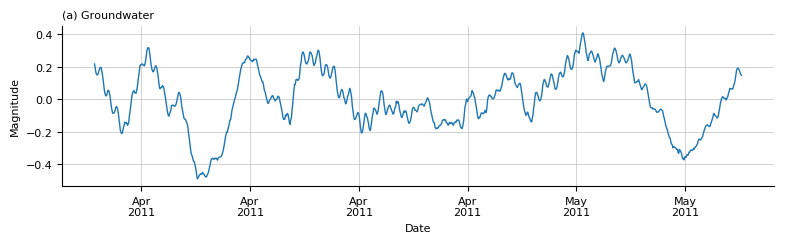

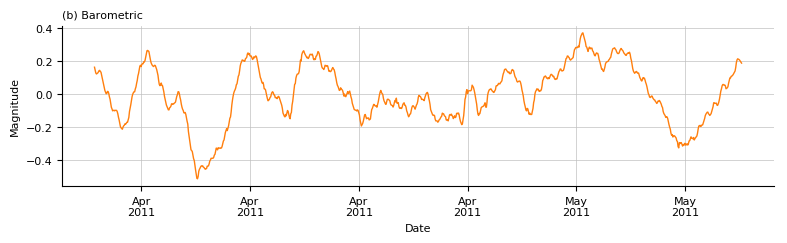

In [37]:
pahute = pd.read_csv('Pahute_Mesa.csv', index_col=0, parse_dates=True).resample('1H').first()[:1000]
pahute.GW = pahute.GW-pahute.GW.mean()
pahute.BA = pahute.BA-pahute.BA.mean()

f,s = create_formatted_plot(xlabel='Date', ylabel='Magnitude', title='(a) Groundwater')
s.plot(pahute.GW)
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))

f,s = create_formatted_plot(xlabel='Date', ylabel='Magnitude', title='(b) Barometric')
s.plot(pahute.BA, c='C1')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))

plt.show();

## 3.2. Fourier Transform

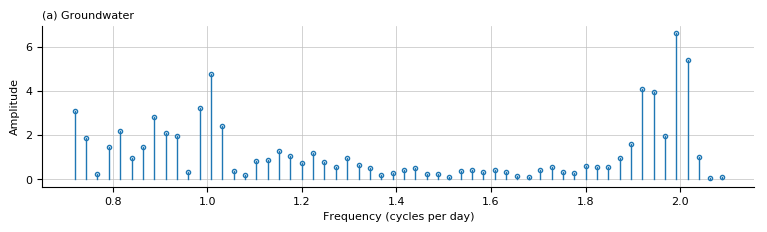

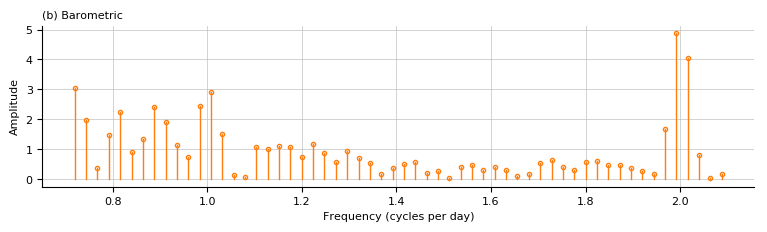

In [38]:
F,A = calculate_fft(np.array(pahute.GW), Fs=24.)

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Amplitude', title='(a) Groundwater')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], A[(F>0.7)&(F<2.1)])

F,A = calculate_fft(np.array(pahute.BA), Fs=24.)
f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Amplitude', title='(b) Barometric')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], A[(F>0.7)&(F<2.1)], c='C1')

plt.show();

## 3.3. Correlation in the frequency domain: Coherence

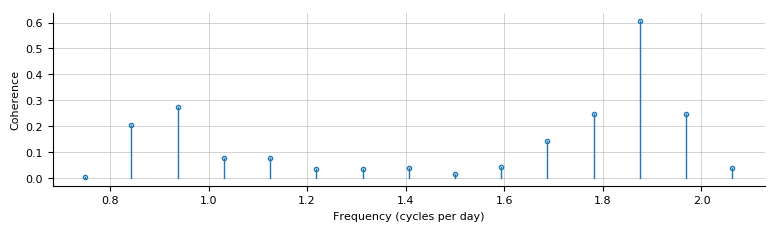

In [39]:
F, coh = sc.signal.coherence(np.array(pahute.GW), np.array(pahute.BA), fs=24.)

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Coherence')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], 1.-coh[(F>0.7)&(F<2.1)])

plt.show();

## 3.4. Periodograms

Periodograms often provide a more robust means of identifying the dominant frequencies present in an observed dataset.

### 3.4.1. Standard

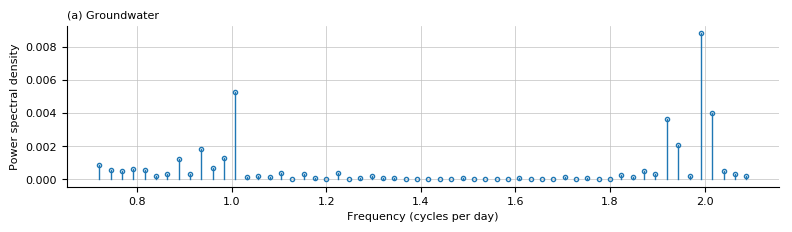

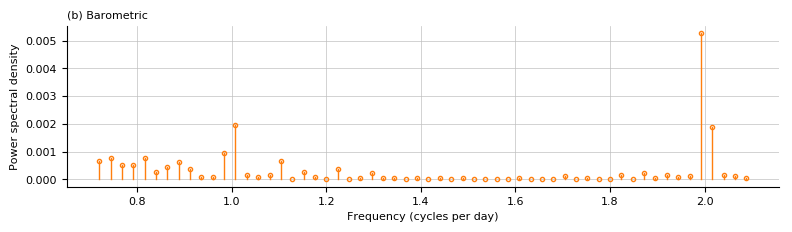

In [40]:
F, psd = sc.signal.periodogram(np.array(pahute.GW), fs=24.)

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Power spectral density', 
                            title='(a) Groundwater')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], psd[(F>0.7)&(F<2.1)])


F, psd = sc.signal.periodogram(np.array(pahute.BA), fs=24.)

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Power spectral density', 
                            title='(b) Barometric')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], psd[(F>0.7)&(F<2.1)], c='C1')

plt.show();

### 3.4.2. Welch

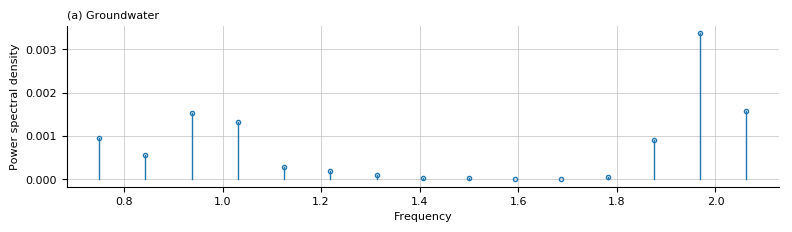

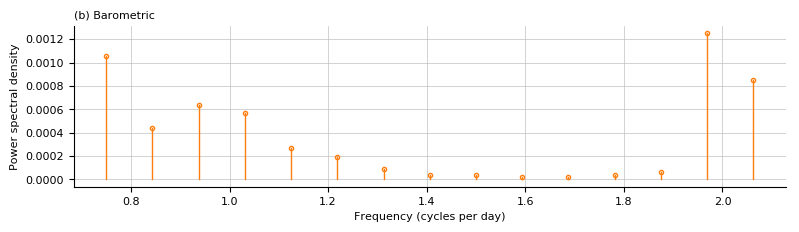

In [41]:
F, psd = sc.signal.welch(np.array(pahute.GW), fs=24.)

f,s = create_formatted_plot(xlabel='Frequency', ylabel='Power spectral density', title='(a) Groundwater')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], psd[(F>0.7)&(F<2.1)])

F, psd = sc.signal.welch(np.array(pahute.BA), fs=24.)
f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Power spectral density', 
                            title='(b) Barometric')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], psd[(F>0.7)&(F<2.1)], c='C1')

plt.show();

### 3.4.3. Cross-spectral density

C:\Users\tur25d\Anaconda2\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


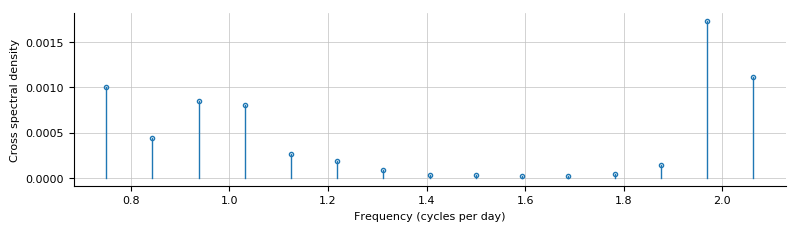

In [42]:
F, csd = sc.signal.csd(np.array(pahute.GW), np.array(pahute.BA), fs=24.)
f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Cross spectral density')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], csd[(F>0.7)&(F<2.1)])

plt.show();

### 3.4.4. Lomb-Scargle

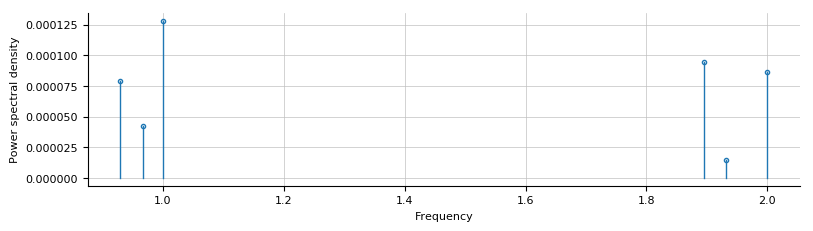

In [43]:
F = np.array([0.929536, 0.966446, 1.000000, 1.895982, 1.932274, 2.000000])
psd = sc.signal.lombscargle(np.arange(len(np.array(pahute.GW))), np.array(pahute.GW), freqs=F)

f,s = create_formatted_plot(xlabel='Frequency', ylabel='Power spectral density')
frequency_domain_plot(f, s, F, psd)

plt.show();

### 3.4.5. Harmonic least squares

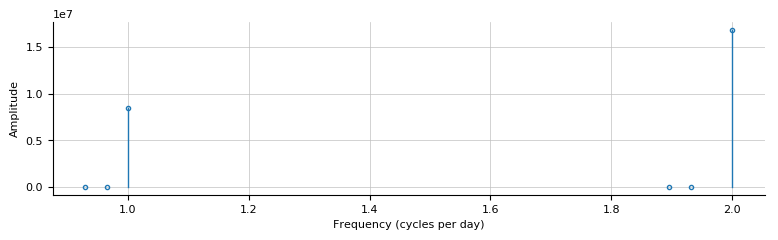

In [44]:
def hals(ft, fs):
    t = np.arange(len(ft))*fs
    freqs = np.array([0.929536, 0.966446, 1.000000, 1.895982, 1.932274, 2.000000])
    N = len(ft)
    f = 2.*np.pi*freqs
    num_freqs = len(f)
    phi = np.empty([N, 2*num_freqs+1])
    for j in range(num_freqs):
        phi[:,2*j]   = np.cos(f[j]*t)
        phi[:,2*j+1] = np.sin(f[j]*t)
    phi[:,-1] = 1
    theta, ssr, rank, singular = np.linalg.lstsq(phi, ft, rcond=None)    
    Z = theta[:-1:2] + theta[1:-1:2]*1j
    amplitudes = np.abs(Z)
    return freqs, amplitudes

F,A = hals(np.array(pahute.GW), fs=24.)

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Amplitude')
frequency_domain_plot(f, s, F, A)

plt.show();

## 3.5. Example application: Estimation of aquifer specific storage from calculated amplitude values

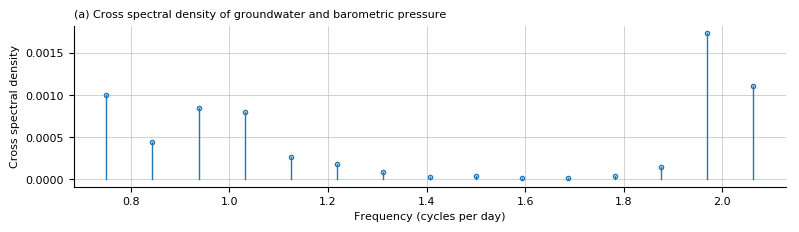

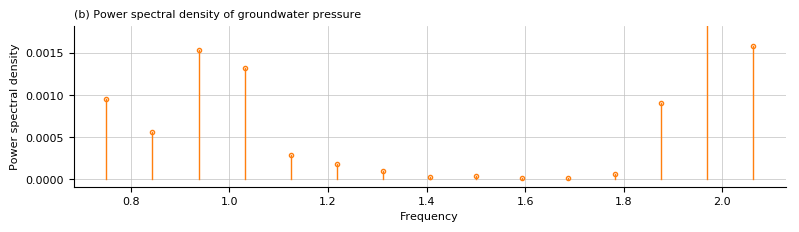

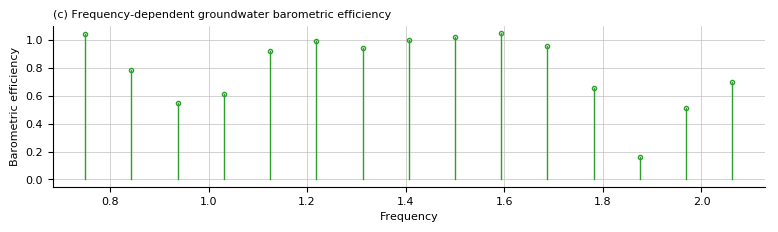

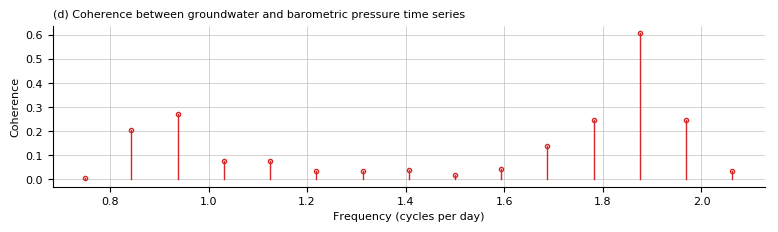

In [46]:
pahute = pd.read_csv('Pahute_Mesa.csv', index_col=0, 
                     parse_dates=True).resample('1H').first()[:1000]
pahute.GW = pahute.GW-pahute.GW.mean()
pahute.BA = pahute.BA-pahute.BA.mean()

F, csd = sc.signal.csd(np.array(pahute.GW), np.array(pahute.BA), fs=24.)

f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Cross spectral density',
                            title='(a) Cross spectral density of groundwater and barometric pressure')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], csd[(F>0.7)&(F<2.1)], c='C0')
ylim = s.get_ylim()

F, psd = sc.signal.welch(np.array(pahute.GW), fs=24.)
f,s = create_formatted_plot(xlabel='Frequency', ylabel='Power spectral density',
                            title='(b) Power spectral density of groundwater pressure')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], psd[(F>0.7)&(F<2.1)], c='C1')
s.set_ylim(ylim)

BE = csd/psd
f,s = create_formatted_plot(xlabel='Frequency', ylabel='Barometric efficiency',
                            title='(c) Frequency-dependent groundwater barometric efficiency')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], BE[(F>0.7)&(F<2.1)], c='C2')

F, coh = sc.signal.coherence(np.array(pahute.GW), np.array(pahute.BA), fs=24.)
f,s = create_formatted_plot(xlabel='Frequency (cycles per day)', ylabel='Coherence',
                            title='(d) Coherence between groundwater and barometric pressure time series')
frequency_domain_plot(f, s, F[(F>0.7)&(F<2.1)], 1.-coh[(F>0.7)&(F<2.1)], c='C3')

plt.show();

# 4.0. HydroGeoSines

To conclude, I'd just like to talk briefly about HydroGeoSines.

Many of the methods demonstrated today have been incorporated into the Python package "HydroGeoSines", which is available from GitHub here:

https://github.com/HydroGeoSines/HydroGeoSines

Currently, two example notebooks are available, which demonstrate the capabilities of the package:

https://github.com/HydroGeoSines/HydroGeoSines/blob/master/examples/Notebooks/Groundwater_head_correction.ipynb

https://github.com/HydroGeoSines/HydroGeoSines/blob/master/examples/Notebooks/Estimation_of_K_Ss_BE.ipynb

This package is intended to make these methods of interpretation more accessible, as well as providing data wrangling tools to simplify the cleaning of time series data prior to analysis. I am one of three researchers who are actively involved in developing HydroGeoSines, which is still in its early stages. Please get in touch if you would like any further information, especially if you believe the package would be of benefit to your work.